# Predicting Party Affiliation of US Congress Members with Machine Learning

The goal of this project is to predict the party affiliation of US House of Representative members based on their voting patterns with machine learning. I am using the data from [UC Irvine’s ML Repository](https://archive.ics.uci.edu/dataset/105/congressional+voting+records) that includes US Congressional voting records on some key bills introduced in 1984. 

## Part 1. Preparing the dataset for analysis

Before we can manipulate the data in a meaningful way, it has to be transformed into a more convenient format. 

In [1]:
# Import the dataset (to run locally, install the ucimlrepo library first)
from ucimlrepo import fetch_ucirepo
import pandas as pd

# fetch dataset
congressional_voting_records = fetch_ucirepo(id=105)

# data (as pandas dataframes)
voting_record = congressional_voting_records.data.features
party_affiliation = congressional_voting_records.data.targets

In [2]:
voting_record

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,n,n,y,y,y,y,n,n,y,y,n,y,y,y,n,y
431,n,n,y,n,n,n,y,y,y,y,n,n,n,n,n,y
432,n,NaN,n,y,y,y,n,n,n,n,y,y,y,y,n,y
433,n,n,n,y,y,y,NaN,NaN,NaN,NaN,n,y,y,y,n,y


In [3]:
party_affiliation

,Class
0,republican
1,republican
2,democrat
3,democrat
4,democrat
...,...
430,republican
431,democrat
432,republican
433,republican


For simplicity, we will use 4 voting sessions from this dataset to predict party affiliation. For the model to work, all the values in the dataset need to be quantified. We see that votes are represented either by 'y' (yea) or 'n' (nay), while party affiliation is represented either by 'republican' or 'democrat'. To quantify the data, we will replace all yeas with '1's, nays with '0's, Democratic affiliation will be marked with '1's, and Republican affiliation with '0's. 

Some data in the voting record is missing, so all the rows with missing data also need to be removed for the algorithm to work properly. 

In [4]:
# keep 4 voting sessions and combine members' party affiliation with their voting record
voting_record = voting_record[['water-project-cost-sharing',
                               'el-salvador-aid',
                               'education-spending',
                               'physician-fee-freeze']]
votes = voting_record.copy()
votes.insert(0, 'party-affiliation', party_affiliation['Class'], True)

# quantify the data
votes[:][votes == 'y'] = 1.0
votes[:][votes == 'n'] = 0.0
votes[:][votes == 'republican'] = 0
votes[:][votes == 'democrat'] = 1

# remove all rows that contain NaN (missing data or third party representatives)
votes = votes.dropna()
votes

,party-affiliation,water-project-cost-sharing,el-salvador-aid,education-spending,physician-fee-freeze
0,0,1.0,1.0,1.0,1.0
1,0,1.0,1.0,1.0,1.0
5,1,1.0,1.0,0.0,0.0
6,1,1.0,1.0,0.0,1.0
7,0,1.0,1.0,0.0,1.0
...,...,...,...,...,...
427,0,0.0,1.0,1.0,1.0
430,0,0.0,1.0,1.0,1.0
431,1,0.0,0.0,0.0,0.0
433,0,0.0,1.0,1.0,1.0


While Democrats are represented more extensively than Republicans in this formatted dataset, we should still have enough data to make predictions.

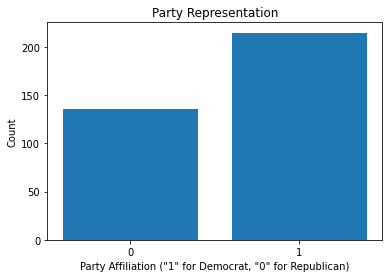

In [5]:
# create a histogram with matplotlib for the party representation in the modified dataset
import matplotlib.pyplot as plt

plt.hist(votes['party-affiliation'], bins=[-0.5, 0.5, 1.5], rwidth=0.8, align='mid')
plt.title('Party Representation')
plt.xlabel('Party Affiliation ("1" for Democrat, "0" for Republican)')
plt.ylabel('Count')
plt.xticks([0, 1], ['0', '1'])

# Display the plot
plt.show()

Finally, we need to split the data into Training Data and Test Data so that we can train the model on some 'known' data and then check how well it performs on additional data. We have 343 rows, so we can select the first 270 rows for training (around 80%), and the remaining 73 rows for testing the model (around 20%). 

In [6]:
train = votes.head(270)
test = votes.tail(73)

## Part 2. Training

We are going to use multiple linear regression to model the relationship between the voting pattern and party affiliation of US House of Representative members. The following equation represents the multiple linear regression model:

$$y_i = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_i x_i, \qquad i \in \{1,2,...,n\} $$

($y_i$ is the dependent variable, $x_1,...,xi$ are independent variables)

The idea behind most multiple linear regression algorithms is to find the values of the coefficients $\beta_0, \beta_1,..., \beta_i$ that minimize the sum of squared differences between the actual datapoints and the points on the calculated best-fitting line (so, using this best-fitting line, it is possible to predict the dependent variable $y_i$ based on multiple independent variables $x_1,...,x_i$). 

Linear regression is a simple yet powerful supervised machine learning tool. However, linear regression works well only if the relationship between the chosen dependent and independent variables is close to linear. In the end, we will check if this approach is sufficiently accurate for this project.

In [7]:
# using scikit-learn library
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

In [8]:
# we are going to predict the party affiliation based on the voting pattern throughout 4 voting sessions:
predictors = ['water-project-cost-sharing',
              'el-salvador-aid',
              'education-spending',
              'physician-fee-freeze']
target = 'party-affiliation'

# training the model
reg.fit(train[predictors], train[target])

LinearRegression()

Now we can use this model to predict the party affiliation of the remaining members of the congress.

In [9]:
# feed the Test Data to our model to generate predictions for 'party-affiliation'
predictions = reg.predict(test[predictors])

# add the predictions to the Test dataframe for comparison to real values
test = test.copy()
test.insert(1, 'predictions', predictions, True)
test

,party-affiliation,predictions,water-project-cost-sharing,el-salvador-aid,education-spending,physician-fee-freeze
345,0,0.026628,0.0,1.0,1.0,1.0
346,0,0.026628,0.0,1.0,1.0,1.0
347,0,0.026628,0.0,1.0,1.0,1.0
348,1,0.895091,0.0,0.0,1.0,0.0
349,0,0.056299,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...
427,0,0.026628,0.0,1.0,1.0,1.0
430,0,0.026628,0.0,1.0,1.0,1.0
431,1,0.992426,0.0,0.0,0.0,0.0
433,0,0.026628,0.0,1.0,1.0,1.0


 The predictions we get are numbers between 0 and 1, while the representative can be either a Democrat ('1') or a Republican ('0'), so the predictions need to be rounded to closest integers.

In [10]:
test['predictions'] = test['predictions'].round().astype(int)
test

,party-affiliation,predictions,water-project-cost-sharing,el-salvador-aid,education-spending,physician-fee-freeze
345,0,0,0.0,1.0,1.0,1.0
346,0,0,0.0,1.0,1.0,1.0
347,0,0,0.0,1.0,1.0,1.0
348,1,1,0.0,0.0,1.0,0.0
349,0,0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...
427,0,0,0.0,1.0,1.0,1.0
430,0,0,0.0,1.0,1.0,1.0
431,1,1,0.0,0.0,0.0,0.0
433,0,0,0.0,1.0,1.0,1.0


## Part 3. Model Accuracy Evaluation

We will use Mean Absolute Error to evaluate the accuracy of the model obtained through linear regression. The mean absolute error is calculated with the following formula:

$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$, where $y_i$ is the actual value, and $\hat{y}_i$ is the predicted value.

In [11]:
from sklearn.metrics import mean_absolute_error
error = mean_absolute_error(test['party-affiliation'], test['predictions'])
error

0.0958904109589041

So, the model was on average 0.096 off the actual value for the party affiliation of the Congress members in the Test Dataset. Considering that the only two possible values for the party affiliation are 1 for Democrats and 0 for Republicans, MAE of 0.096 (<10% of 1) indicates high accuracy of our model.